In [19]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.animation import FuncAnimation
from scipy.spatial.distance import euclidean

from simulation.simulator import Simulator

In [20]:
def diffeq_lorenz_system(t, z, args):
    """
    Coupled differential equations representing the Lorenz system.
    """
    sigma, rho, beta = args
    x1, x2, x3 = z
    dx1dt = sigma * (x2 - x1)
    dx2dt = x1 * (rho - x3) - x2
    dx3dt = x1 * x2 - beta * x3
    return [dx1dt, dx2dt, dx3dt]

In [21]:
sigma = 10.0
rho = 28.0
beta = 8.0 / 3.0

ics = []
for i in range(0, 100):
    x1_0 = 1.0 + 0.1 * i
    x2_0 = 1.0
    x3_0 = 1.0
    ics.append([x1_0, x2_0, x3_0])

In [22]:
scipy_sim = Simulator("scipy")

In [23]:
# if you'd like to see the improvement via multiprocessing, uncomment this to see how slowly sequential processing runs
# scipy_sim.cpu_sequential_solve_ics(
#     ics, diffeq_lorenz_system, [sigma, rho, beta], 0.0, 100.0, 0.01
# )

In [24]:
scipy_sim.cpu_parallel_solve_ics(
    ics=ics,
    num_processes=10,
    diffeq_func=diffeq_lorenz_system,
    args=[sigma, rho, beta],
    ti=0.0,
    tf=100.0,
    dt=0.01,
)

Benchmarked time = 0.8513069152832031
Function benchmarked was: <function Simulator.cpu_parallel_solve_ics at 0x76ddea577130>


In [25]:
# parallel operations not garunteed to return solutions in order, so we sort them afterwards for visualization
sorted_sols = sorted(scipy_sim.sols, key=lambda x: x[1]["ic"])

In [26]:
def compute_distances(first_solution, all_solutions):
    time_steps = len(first_solution[0]["t"])
    num_solutions = len(all_solutions)

    y_distances = np.zeros((num_solutions, time_steps))
    ic_distances = np.zeros(num_solutions)

    for i, sol in enumerate(all_solutions):
        ic_distances[i] = euclidean(first_solution[1]["ic"], sol[1]["ic"])
        for t in range(time_steps):
            y_distances[i, t] = euclidean(
                (
                    first_solution[0]["y"][0][t],
                    first_solution[0]["y"][1][t],
                    first_solution[0]["y"][2][t],
                ),
                (sol[0]["y"][0][t], sol[0]["y"][1][t], sol[0]["y"][2][t]),
            )

    return y_distances, ic_distances


first_solution = sorted_sols[0]

y_distances, ic_distances = compute_distances(first_solution, sorted_sols)

In [27]:
y_distances.shape, ic_distances.shape

((100, 10000), (100,))

In [28]:
average_y_distances = np.average(y_distances[1:], axis=1)

In [29]:
max_y_distances = np.max(y_distances[1:], axis=1)

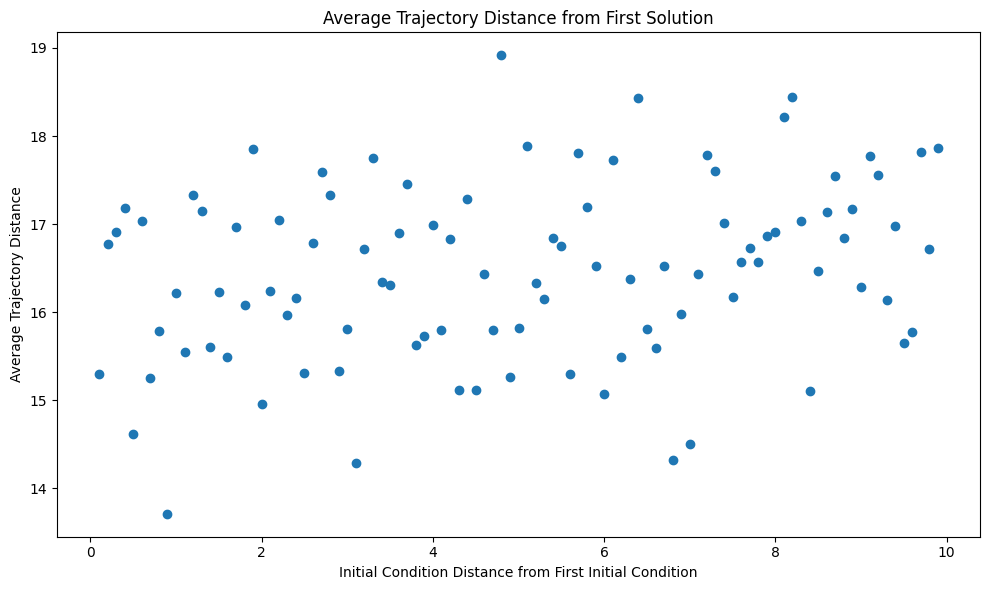

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(ic_distances[1:], average_y_distances)

plt.title("Average Trajectory Distance from First Solution")
plt.xlabel("Initial Condition Distance from First Initial Condition")
plt.ylabel("Average Trajectory Distance")
plt.tight_layout()
plt.show()

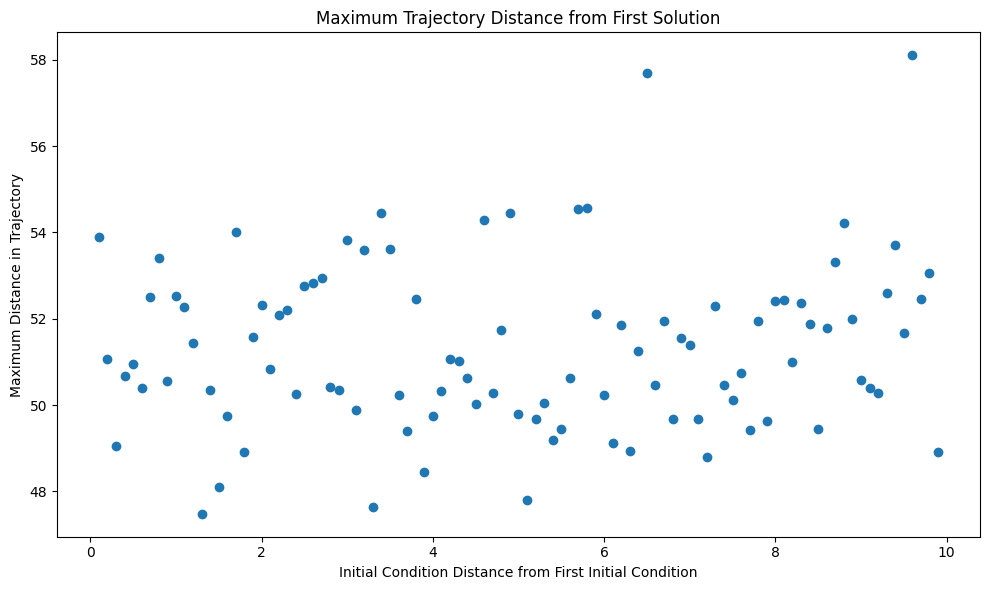

In [31]:
plt.figure(figsize=(10, 6))
plt.scatter(ic_distances[1:], max_y_distances)

plt.title("Maximum Trajectory Distance from First Solution")
plt.xlabel("Initial Condition Distance from First Initial Condition")
plt.ylabel("Maximum Distance in Trajectory")
plt.tight_layout()
plt.show()

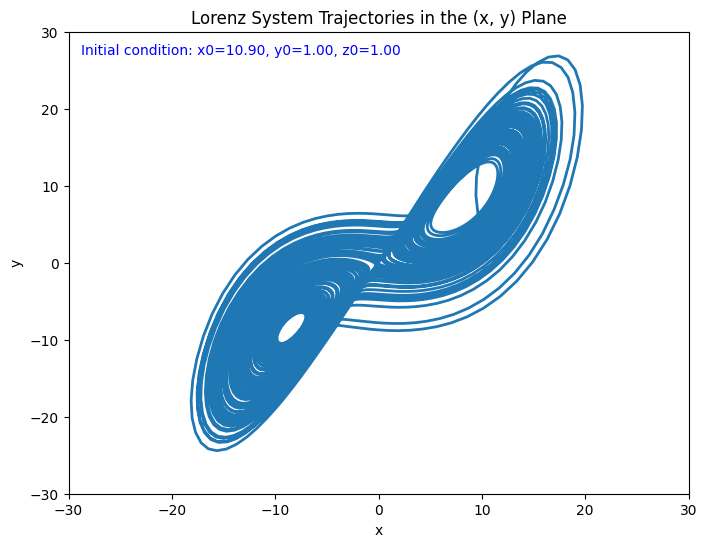

In [32]:
fig, ax = plt.subplots(figsize=(8, 6))
ax.set_xlim([-30, 30])
ax.set_ylim([-30, 30])
ax.set_xlabel("x")
ax.set_ylabel("y")
ax.set_title("Lorenz System Trajectories in the (x, y) Plane")

line, = ax.plot([], [], lw=2)
init_text = ax.text(0.02, 0.95, '', transform=ax.transAxes, fontsize=10, color='blue')

def init():
    line.set_data([], [])
    init_text.set_text('')
    return line,

def update(frame):
    sol = sorted_sols[frame][0]['y']
    x = sol[0]
    y = sol[1]
    line.set_data(x, y)
    initial_condition = sorted_sols[frame][1]['ic']
    init_text.set_text(f"Initial condition: x0={initial_condition[0]:.2f}, y0={initial_condition[1]:.2f}, z0={initial_condition[2]:.2f}")
    return line,

# Create the animation object
ani = FuncAnimation(fig, update, frames=len(sorted_sols), init_func=init, blit=True, interval=100)

# Save the animation as a video
ani.save("lorenz_trajectories.mp4", writer='ffmpeg', dpi=200)

plt.show()

In [ ]:
ani.save("lorenz_trajectories.gif", writer='ffmpeg', dpi=200)